# Main Notebook to Perform Trading

### Imports

In [2]:
import matplotlib.pyplot as plt

from data_collection import get_historical_data, detect_stock_pairs
from testing import backtest_pair_with_capital
from plotting import plot_pair_signals

### Getting Data

In [3]:
# Define the ticker list
# Always include "SPY" to benchmark vs. S&P
tickers = [
    # Technology
    "AAPL",  # Apple (tech)
    "MSFT",  # Microsoft (tech)
    "GOOG",  # Alphabet (tech)
    "AMZN",  # Amazon (e-commerce/tech)
    "META",  # Meta (Facebook)
    "NVDA",  # NVIDIA (semiconductors)
    "IBM",   # IBM (enterprise tech)
    "ORCL",  # Oracle (enterprise tech)
    "INTC",  # Intel (semiconductors)
    "ADBE",  # Adobe (software)
    "CRM",   # Salesforce (enterprise software)

    # Consumer Goods & Retail
    "KO",    # Coca-Cola (beverage)
    "PEP",   # PepsiCo (beverage/food)
    "WMT",   # Walmart (retail)
    "COST",  # Costco (retail)
    "PG",    # Procter & Gamble (consumer goods)

    # Healthcare
    "JNJ",   # Johnson & Johnson (healthcare)

    # Financials
    "GS",    # Goldman Sachs (banking)

    # Automotive & Clean Energy
    "TSLA",  # Tesla (EV/clean energy)

    # Entertainment & Media
    "NFLX",  # Netflix (streaming)
    "DIS",   # Disney (entertainment)

    # Food & Beverage
    "MCD",   # McDonald's (fast food)
    "SBUX",  # Starbucks (coffee)

    # Aerospace
    "BA",    # Boeing (aerospace)

    # Benchmark
    "SPY"    # S&P 500 (benchmark)
]

start_date = "2019-12-31"
end_date   = "2024-12-31"
historical_data = get_historical_data(tickers, start=start_date, end=end_date)

print("Historical Data Shape:", historical_data.shape)
display(historical_data.tail())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Historical Data Shape: (1258, 25)


,AAPL,MSFT,GOOG,AMZN,META,NVDA,IBM,ORCL,INTC,ADBE,...,PG,JNJ,GS,TSLA,NFLX,DIS,MCD,SBUX,BA,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-23,255.270004,435.250000,195.990005,225.059998,599.849976,139.669998,221.929993,168.725281,20.200001,446.739990,...,167.091125,145.270004,570.780029,430.600006,911.450012,111.400002,291.290009,87.440002,177.690002,594.690002
2024-12-24,258.200012,439.329987,197.570007,229.050003,607.750000,140.220001,224.410004,170.989731,20.400000,447.940002,...,167.916092,145.850006,582.789978,462.279999,932.119995,112.559998,293.989990,89.910004,179.339996,601.299988
2024-12-26,259.019989,438.109985,197.100006,227.050003,603.349976,139.929993,224.889999,171.259048,20.440001,450.160004,...,169.128708,145.580002,581.229980,454.130005,924.140015,112.550003,294.799988,91.860001,180.380005,601.340027
2024-12-27,255.589996,430.529999,194.039993,223.750000,599.809998,137.009995,222.779999,168.545731,20.299999,446.480011,...,168.502518,145.050003,576.179993,431.660004,907.549988,111.550003,293.619995,92.250000,180.720001,595.010010
2024-12-30,252.199997,424.829987,192.690002,221.300003,591.239990,137.490005,220.250000,166.500763,19.820000,445.799988,...,166.077301,143.339996,573.549988,417.410004,900.429993,110.800003,289.600006,90.580002,176.550003,588.219971


### Find and Pick Pairs

In [4]:
non_spy_data = historical_data.drop(columns=["SPY"], errors='ignore')

# always compare to SPY
spy_series = historical_data["SPY"].dropna()

high_corr_df = detect_stock_pairs(
    non_spy_data,
    corr_threshold=0.5,
    value_diff_threshold=10
)

# pick the top 3 correlations from that DataFrame
top_3_pairs = high_corr_df.head(3)
print("Top 3 pairs (no correlation threshold):")
display(top_3_pairs)

Top 3 pairs (no correlation threshold):


,Stock 1,Stock 2,Correlation
74,NVDA,WMT,0.951660
118,COST,NVDA,0.946035
60,COST,IBM,0.942304


### Compute Statistics and Perform Backtesting

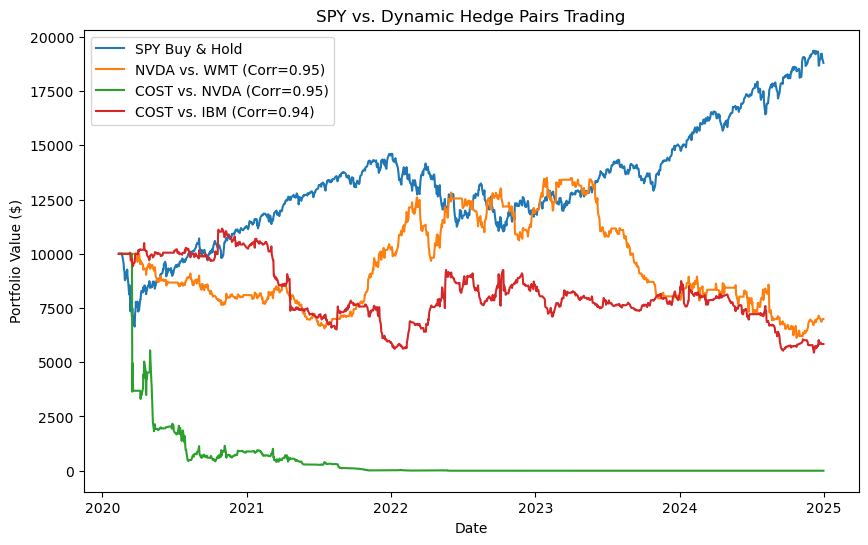

In [ ]:
# Collect backtest DataFrames
all_backtests = []
for i, row in top_3_pairs.iterrows():
    s1 = row["Stock 1"]
    s2 = row["Stock 2"]
    corr_val = row["Correlation"]
    
    bt_df = backtest_pair_with_capital(
        historical_data=historical_data,
        stock1_name=s1,
        stock2_name=s2,
        spy_series=spy_series,
        window=30,
        initial_capital=10000.0,
        z_entry=1.0,
        z_exit=0.0
    )
    pair_label = f"{s1} vs. {s2} (Corr={corr_val:.2f})"
    all_backtests.append((pair_label, bt_df))

# Plot SPY vs. each pair's capital
fig, ax = plt.subplots(figsize=(10, 6))

spy_df = all_backtests[0][1]

# Plot SPY
ax.plot(
    spy_df.index,
    spy_df['SPY_BuyHold'],
    label='SPY Buy & Hold',
)

# Plot each pair's strategy
for label, df in all_backtests:
    ax.plot(df.index, df['Strategy_Capital'], label=label)

ax.set_title('SPY vs. Dynamic Hedge Pairs Trading')
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value ($)')
ax.legend()
plt.show()

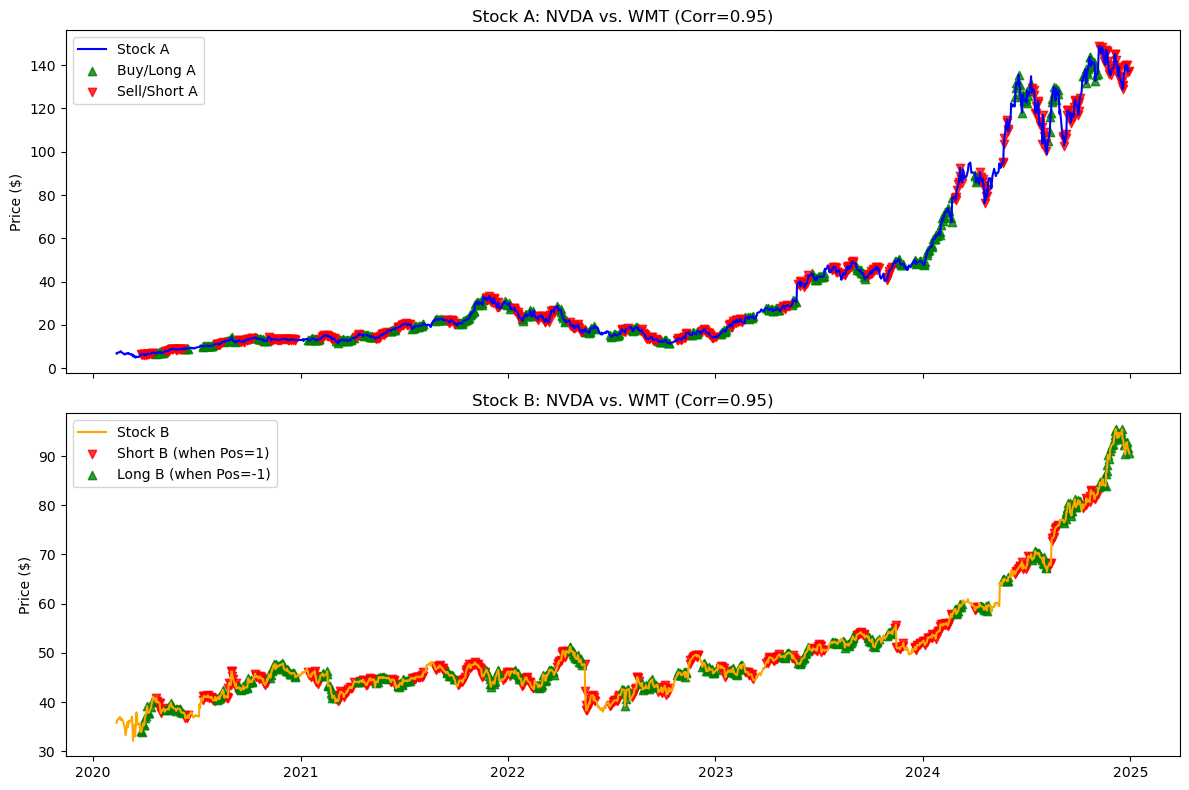

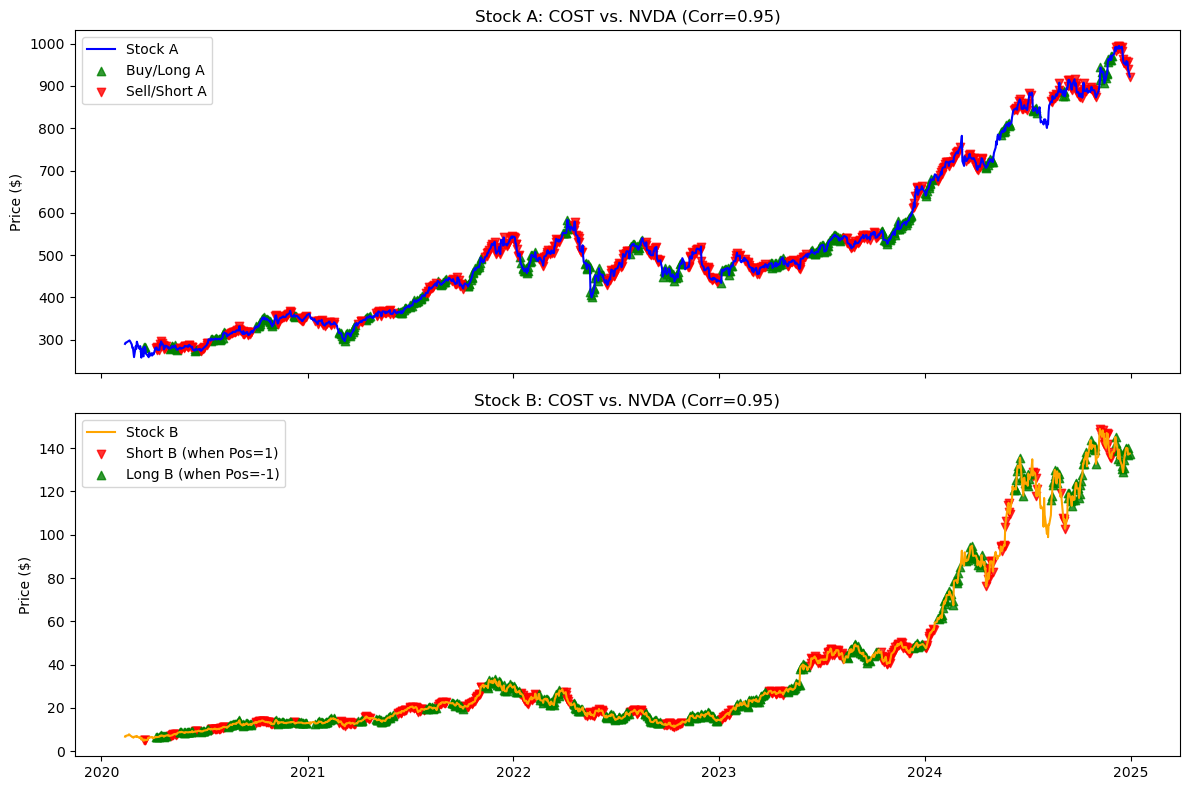

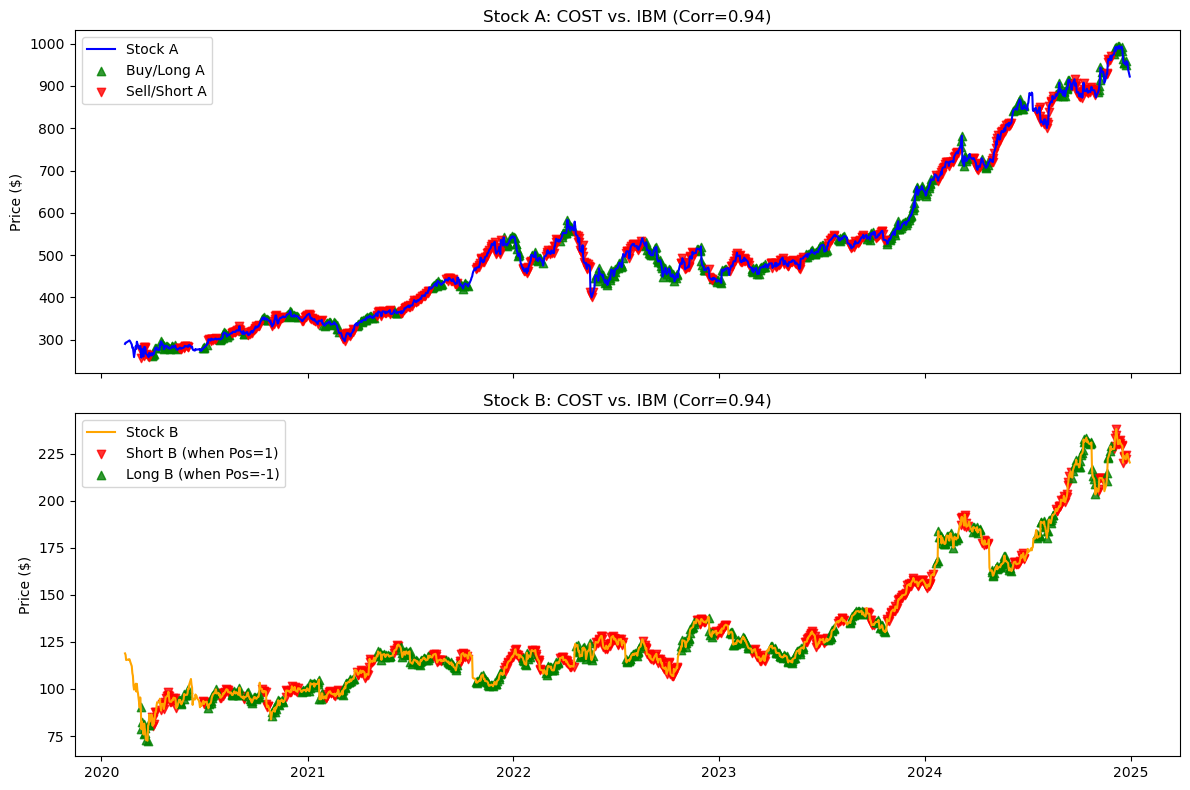

In [6]:
for label, df in all_backtests:
    plot_pair_signals(df, pair_label=label)